Importing libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import matplotlib.patches as mpatches

Importing dataset (Overseas_Flag file is where we created boolean field based on supplier location)

In [5]:
planning_report = pd.read_excel("Planning Parameter Report.xlsx")
inventory_report = pd.read_excel("Inventory On Hand Report.xlsx")
usage_history = pd.read_excel("Component Usage History (Last 52 Weeks).xlsx")
overseas_report = pd.read_excel("Planning_Parameter_Report_With_Overseas_Flag.xlsx")

In [6]:
overseas_report.head()

,Item_Number,PrimeVendor,PrimeVendorNumber,Overseas_Flag
0,5910C,NaN,NaN,no
1,5910CX2,NaN,NaN,no
2,5910CX2-9A,NaN,NaN,no
3,5910CX2-9A1,NaN,NaN,no
4,5910CX2-9B,NaN,NaN,no


In [4]:
overseas_report['Overseas_Flag'].value_counts()

no     106954
yes       367
Name: Overseas_Flag, dtype: int64

Filtering planning report file based on item numbers found in component usage history

In [7]:
planning_report_filtered=planning_report[planning_report['Item_Number'].isin(usage_history['Item_Number'])]

In [8]:
merge_df=pd.merge(planning_report_filtered, usage_history,  left_on='Item_Number', right_on='Item_Number', how='inner')
merge_df=pd.merge(merge_df,overseas_report[['Item_Number','Overseas_Flag']], left_on='Item_Number', right_on='Item_Number', how='left')

In [9]:
merge_df.head()

,Item_Number,Item_Type,Item_Description,Unit of Measure,Inventory_Item_Status_Code,Site,OnHandQuantity,Safety Stock,ABC_Inventory_Classification,PlanningMethod,...,Week45,Week46,Week47,Week48,Week49,Week50,Week51,Week52,Total 52 Weeks,Overseas_Flag
0,ERAA22608A0,PURCHASED ITEM,BASE ~ EPRV 20; CL150 ASME B16.5 PATTERN; FLAT...,EA,Active,EMR,0.0,NaN,NaN,MRP planning,...,0,0,0,0,0,0,0,0,-45,no
1,ERAA22609A2,PURCHASED ITEM,BASE ASSY ~ EPRV; 20; CL150 FF; ANSI; FORGED W...,EA,Active,EMR,0.0,NaN,NaN,MRP planning,...,0,-2,0,0,0,0,0,0,-66,no
2,ERAA22609A3,SUBASSEMBLY,BASE ASSY ~ EPRV; 20; API; FORGED WITH WELDED ...,EA,Active,EMR,0.0,NaN,NaN,MRP planning,...,0,0,0,0,0,0,0,0,-29,no
3,ERAA22610A0,PURCHASED ITEM,BASE ~ EPRV; 24; ANSI; FORGED,EA,Active,EMR,8.0,10.0,NaN,MRP planning,...,-1,0,0,0,-2,0,-1,-2,-18,yes
4,ERAA22611A2,SUBASSEMBLY,BASE ASSY ~ EPRV; 24; CL150 FF; ANSI; FORGED W...,EA,Active,EMR,0.0,NaN,NaN,MRP planning,...,0,-1,0,-1,0,0,0,0,-13,no


## ABCD Calculation

In [10]:
def classify_item_based_on_combined_score(row):
    combined_score_thresholds = {
        'AA': merge_df['combined_score'].quantile(0.98),
        'A': merge_df['combined_score'].quantile(0.85),  
        'B': merge_df['combined_score'].quantile(0.70), 
    }
    
    if row['ABC_Class'] == 'To Be Classified':
        if row['combined_score'] > combined_score_thresholds['AA']:
            return 'AA'
        elif (row['combined_score'] > combined_score_thresholds['A']): #& (row['combined_score'] < combined_score_thresholds['AA']):
            return 'A'
        elif (row['combined_score'] > combined_score_thresholds['B']): #& (row['combined_score'] < combined_score_thresholds['A']):
            return 'B'
        else:
            return 'C'
        if debug:
            print(f"Combined Score: {row['combined_score']}, Classification: {classification}")
        return classification
    else:
        return row['ABC_Class']  

In [11]:
#melting dataframe comtaining week usage data
demand_melted_df = pd.melt(merge_df, 
id_vars=['Item_Number', 'ORG'], 
value_vars=[f'Week{i}' for i in range(1, 53)],
var_name='Week', 
value_name='Demand')


In [12]:

#grouping by demand and calculating cdf
demand_frequencies = demand_melted_df.groupby(['Item_Number', 'Demand']).size().reset_index(name='Frequency')
demand_frequencies['Total_Observations'] = demand_frequencies.groupby('Item_Number')['Frequency'].transform('sum')
demand_frequencies['Probability'] = demand_frequencies['Frequency'] / demand_frequencies['Total_Observations']
demand_frequencies = demand_frequencies.sort_values(['Item_Number', 'Demand'])
demand_frequencies['CDF'] = demand_frequencies.groupby('Item_Number')['Probability'].cumsum()


Coef of variance calculation

In [13]:

#calculating mean and stdev
week_columns = [f'Week{i}' for i in range(1, 53)]

merge_df['mean'] = merge_df[week_columns].mean(axis=1)
merge_df['std'] = merge_df[week_columns].std(axis=1)

# calculating the variance in demand for the items
merge_df ['coefficient_of_variation'] = (merge_df ['std'] / merge_df ['mean']).abs()
# Accessing the coefficient of variation column
coeff_of_variation = merge_df['coefficient_of_variation']


In [14]:

demand_variance_array = np.array(coeff_of_variation)

demand_variance_60percentile = coeff_of_variation.quantile([0.60]).iloc[0]   
demand_variance_median = coeff_of_variation.median()


In [15]:
demand_variance_60percentile, demand_variance_median

(5.332516277283601, 4.705247800354947)

In [16]:
# reclassifying the D items based on the percetile threshold of the coeefficient of variance for each item
merge_df['ABC_Class'] = merge_df['coefficient_of_variation'].apply(lambda x: 'D' if x >= demand_variance_60percentile
                                                                   else 'To Be Classified')


In [17]:
# reclassifying with ABC items using the cost percentiles based on the proportion of spend of an item as compared to total spend
merge_df['item_standard_cost'] = merge_df['Product Standard Cost']
merge_df['Total 52 Weeks'] = merge_df['Total 52 Weeks'].abs()

merge_df['item_spend_52weeks'] = (merge_df['item_standard_cost'] * merge_df['Total 52 Weeks'])

total_spending = merge_df['item_spend_52weeks'].sum()

merge_df['proportion_total_spend'] = (merge_df['item_spend_52weeks']/total_spending) * 100


In [18]:
high_demand_variance = merge_df['coefficient_of_variation'].quantile(0.25)
low_demand_variance = merge_df['coefficient_of_variation'].quantile(0.75)
high_spending_proportion = merge_df['proportion_total_spend'].quantile(0.75)
moderate_spending_proportion = merge_df['proportion_total_spend'].quantile(0.25)


In [19]:
# Sum of spend per class
total_spend_per_class = merge_df.groupby('ABC_Class')['coefficient_of_variation'].sum()

# Overall total spend
overall_total_spend = merge_df['coefficient_of_variation'].sum()

# Percentage of spend for each class
percentage_spend_per_class = (total_spend_per_class / overall_total_spend) * 100


percentage_spend_per_class

ABC_Class
D                   59.58771
To Be Classified    40.41229
Name: coefficient_of_variation, dtype: float64

In [20]:
merge_df['coefficient_of_variation']

0       4.323868
1       2.839089
2       4.281910
3       2.350749
4       3.253957
          ...   
5837    7.211103
5838    7.211103
5839    7.211103
5840    5.048782
5841    7.211103
Name: coefficient_of_variation, Length: 5842, dtype: float64

In [21]:
merge_df['coefficient_of_variation'].max(), merge_df['coefficient_of_variation'].min()

(7.2111025509279925, 0.3890904686745604)

In [22]:
demand_variance_weight = 0.20
spending_proportion_weight = 0.80

# normalize the weights if not equal to 1
total_weight = demand_variance_weight + spending_proportion_weight
demand_variance_weight /= total_weight
spending_proportion_weight /= total_weight


In [23]:

merge_df['weighted_demand_variance_score'] = (1 - (merge_df['coefficient_of_variation'] / merge_df['coefficient_of_variation'].max()))* demand_variance_weight
merge_df['weighted_spending_proportion_score'] = (merge_df['proportion_total_spend'] / merge_df['proportion_total_spend'].max())* spending_proportion_weight
merge_df['combined_score'] = merge_df['weighted_demand_variance_score'] + merge_df['weighted_spending_proportion_score']

merge_df['ABC_Class'] = merge_df.apply(classify_item_based_on_combined_score, axis=1)

<Axes: >

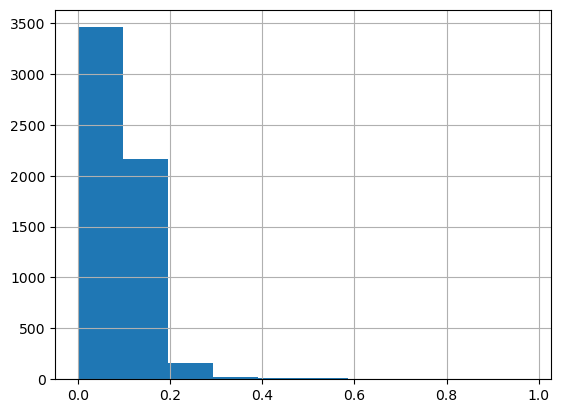

In [24]:
merge_df['combined_score'].hist() 

In [25]:
merge_df['ABC_Class'].value_counts()

D     2343
C     1752
B      873
A      760
AA     114
Name: ABC_Class, dtype: int64

<Axes: >

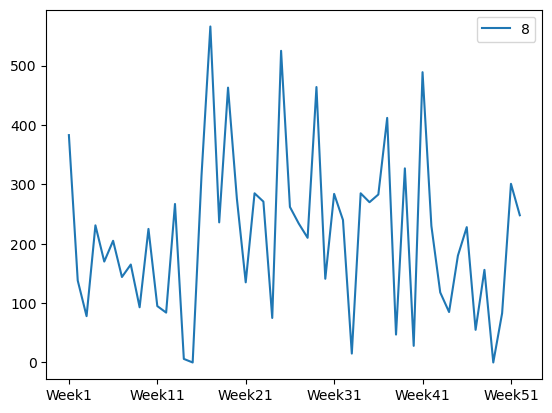

In [27]:
merge_df[merge_df['Item_Number']==merge_df[merge_df['ABC_Class']=='AA'].iloc[0,0]][week_columns].T.abs().plot()

<Axes: >

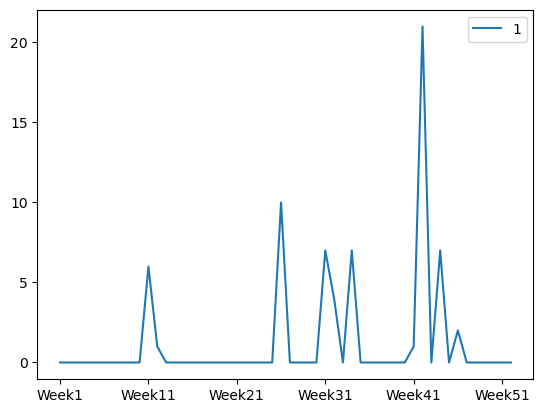

In [28]:
merge_df[merge_df['Item_Number']==merge_df[merge_df['ABC_Class']=='A'].iloc[0,0]][week_columns].T.abs().plot()

<Axes: >

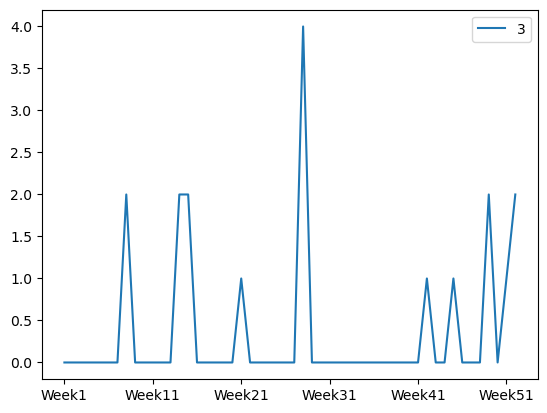

In [29]:
merge_df[merge_df['Item_Number']==merge_df[merge_df['ABC_Class']=='B'].iloc[0,0]][week_columns].T.abs().plot()

<Axes: >

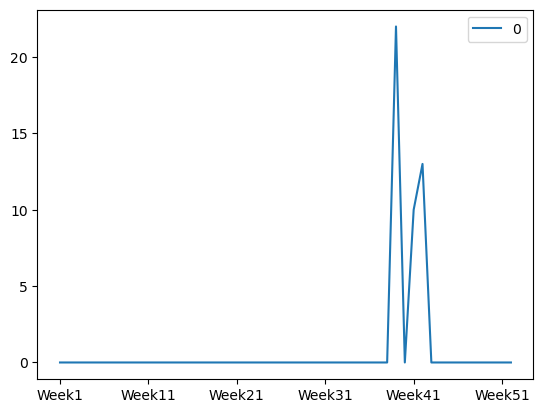

In [30]:
merge_df[merge_df['Item_Number']==merge_df[merge_df['ABC_Class']=='C'].iloc[0,0]][week_columns].T.abs().plot()

<Axes: >

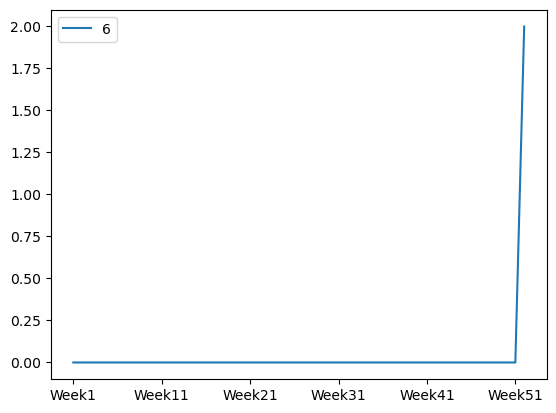

In [31]:
merge_df[merge_df['Item_Number']==merge_df[merge_df['ABC_Class']=='D'].iloc[0,0]][week_columns].T.abs().plot()

In [32]:
merge_df[['Total 52 Weeks','Lead Time','ABC_Class','Item_Description','proportion_total_spend']]

,Total 52 Weeks,Lead Time,ABC_Class,Item_Description,proportion_total_spend
0,45,92.000000,C,BASE ~ EPRV 20; CL150 ASME B16.5 PATTERN; FLAT...,0.044099
1,66,92.000000,A,BASE ASSY ~ EPRV; 20; CL150 FF; ANSI; FORGED W...,0.093076
2,29,102.314583,C,BASE ASSY ~ EPRV; 20; API; FORGED WITH WELDED ...,0.038726
3,18,102.000000,B,BASE ~ EPRV; 24; ANSI; FORGED,0.019104
4,13,109.597916,B,BASE ASSY ~ EPRV; 24; CL150 FF; ANSI; FORGED W...,0.020865
...,...,...,...,...,...
5837,8,24.002083,D,STM PALLET STEM 7/16 X M8;SST CTD SST 316; USA...,0.000421
5838,8,34.002083,D,"PAL PALLET;SPUN;6"" 2010;TEFLON CTD SST 316; US...",0.003224
5839,8,22.000000,D,RETAINER ~ 6; INSERT; USA AIS,0.000337
5840,16,32.000000,C,NUT NUT ~ WING; 220; A1441-006AIS; USA AIS,0.010753


## Safety Stock

Handling 0 Lead Time

In [33]:
# Step 1: Remove items with ABC Class of 'D'
item_nonD = merge_df[merge_df['ABC_Class'] != 'D']

# Step 2: Filter for items with a Lead Time of 0 and select specific columns
filter_items_leadtime = item_nonD.loc[item_nonD['Lead Time'] == 0, ['Item_Number', 'PrimeVendor', 'Lead Time']]

# Step 3: Count how many times each vendor appears in the filtered list
vendor_counts = filter_items_leadtime['PrimeVendor'].value_counts()

# Step 4: Calculate the mean lead time for each vendor, excluding those with a Lead Time of 0
mean_lead_time_per_vendor = item_nonD[item_nonD['Lead Time'] != 0].groupby('PrimeVendor')['Lead Time'].mean()



In [34]:
# Step 6: Replace 0 lead time with the vendor's mean lead time
def replace_zero_lead_time(row, mean_lead_times):
    if row['Lead Time'] == 0:  # Check if the lead time is zero
        return mean_lead_times.get(row['PrimeVendor'], 0)  # Replace with mean lead time of the vendor, default to 0 if not found
    else:
        return row['Lead Time']

# Step 7: Apply the changes
merge_df['Lead Time'] = merge_df.apply(lambda row: replace_zero_lead_time(row, mean_lead_time_per_vendor), axis=1)

In [35]:
#Adding Column Receiving_Days and change it to be 7 or 3 based on overseas flag
merge_df['Receiving_Days'] = np.where((merge_df['ABC_Class'] == 'AA') & (merge_df['Overseas_Flag'] == 'yes'), 7,3)

In [36]:
data_array = merge_df[week_columns].to_numpy()
data_positive = np.abs(data_array)

mean_values_per_item = np.mean(data_positive, axis=1)
percentile_95_per_item = np.percentile(data_positive, 85, axis=1)

# Add mean_values_per_item and percentile_95_per_item to merge_df_new
merge_df['mean'] = mean_values_per_item
merge_df['percentile_95_per_item'] = percentile_95_per_item


In [37]:
merge_df[merge_df['ABC_Class']=='C']['Lead Time'].quantile([0.25,0.5,0.75,1])

0.25     17.000000
0.50     22.000000
0.75     36.523958
1.00    182.000000
Name: Lead Time, dtype: float64

In [38]:
merge_df['ABC_Class'].value_counts()

D     2343
C     1752
B      873
A      760
AA     114
Name: ABC_Class, dtype: int64

In [39]:
import math
def calculate_safety_stock(row):
    #A- one a week
    # AA - thrice a week, B- one 2 week, C- once a month
    # Filter the DataFrame based on the current row's ABC class
    
#     (95 % CI - mean) * 3(days per arrival) / 5 (working days)
    
    if row['ABC_Class']=='AA':
        
        class_df = merge_df[merge_df['ABC_Class'] == row['ABC_Class']]
        # Calculate mean and percentile for the filtered class
        class_mean = class_df['mean'].mean()
        class_percentile_95 = class_df['percentile_95_per_item'].quantile(0.95)
        # Calculate 'Safety Stock cal' for the current row
        #print(class_percentile_95, class_mean,row['Lead Time'] )
        safety_stock_cal = (((1.645 * 0.2*(class_percentile_95 - class_mean) * math.sqrt(row['Lead Time']))*row['Receiving_Days'])/7)
        #safety_stock_cal = (((1.645 * 0.2*(class_percentile_95 - class_mean) )*row['Receiving_Days'])/7)
        coverage = safety_stock_cal*2*4*12
        
    elif row['ABC_Class']=='A':        
        class_df = merge_df[merge_df['ABC_Class'] == row['ABC_Class']]
        # Calculate mean and percentile for the filtered class
        class_mean = class_df['mean'].mean()
        class_percentile_95 = class_df['percentile_95_per_item'].quantile(0.95)
        # Calculate 'Safety Stock cal' for the current row
        #safety_stock_cal = (class_percentile_95 - class_mean)#*(row['Lead Time'])/7
        safety_stock_cal =(((1.645 * 0.2*(class_percentile_95 - class_mean) * math.sqrt(row['Lead Time']))))
        coverage = safety_stock_cal*4*12
    elif row['ABC_Class']=='B':        
        class_df = merge_df[merge_df['ABC_Class'] == row['ABC_Class']]
        # Calculate mean and percentile for the filtered class
        class_mean = class_df['mean'].mean()
        class_percentile_95 = class_df['percentile_95_per_item'].quantile(0.95)
        # Calculate 'Safety Stock cal' for the current row
        #safety_stock_cal = (class_percentile_95 - class_mean)*2#*(row['Lead Time'])/(7*2)
        safety_stock_cal = (((1.645 * 0.2*(class_percentile_95 - class_mean) * math.sqrt(row['Lead Time'])))*2)
        coverage = safety_stock_cal*2*12
    elif row['ABC_Class']=='C':        
        class_df = merge_df[merge_df['ABC_Class'] == row['ABC_Class']]
        # Calculate mean and percentile for the filtered class
        class_mean = class_df['mean'].median()
        class_percentile_95 = class_df['percentile_95_per_item'].quantile(0.95)
        # Calculate 'Safety Stock cal' for the current row
        #safety_stock_cal =(class_percentile_95 - class_mean)*4#*(row['Lead Time'])/(7*4)
        safety_stock_cal = (((1.645 * 0.2*(class_percentile_95 - class_mean) * math.sqrt(row['Lead Time'])))*4)
        coverage = safety_stock_cal*12
        
    elif row['ABC_Class']=='D':       
        safety_stock_cal = 0
        coverage=0
        
    if safety_stock_cal < row['Minimum_Order_Quantity']:
        safety_stock_cal= row['Minimum_Order_Quantity']
    
    return pd.Series([safety_stock_cal,coverage])



In [ ]:
# Apply the function to each row in the DataFrame
merge_df[['Safety_Stock_cal_new1', "Safety Stock Coverage"]] = merge_df.apply(calculate_safety_stock, axis=1) 


In [40]:
def calculate_safety_stock_per_item(row):
    lead_time_weeks = row['Lead Time'] / 7
    safety_stock = (row['percentile_95_per_item'] * lead_time_weeks) - (row['mean'] * lead_time_weeks)
    return safety_stock

# Apply the function to each row in the DataFrame to calculate 'Safety Stock per Item'
merge_df['Safety Stock per Item'] = merge_df.apply(calculate_safety_stock_per_item, axis=1)

In [41]:
df_final=merge_df[['ABC_Class','Minimum_Order_Quantity','Total 52 Weeks','mean','Lead Time','weighted_spending_proportion_score','Safety_Stock_cal_new1']]

In [44]:
merge_df[merge_df['Item_Number']=='NE4503800A0'][['Total 52 Weeks','Safety_Stock_cal_new1','Safety Stock']]

,Total 52 Weeks,Safety_Stock_cal_new1,Safety Stock
2159,4215,131.987277,38.0


In [55]:
merge_df[merge_df['Item_Number']=='NE4503800A0'][week_columns]

,Week1,Week2,Week3,Week4,Week5,Week6,Week7,Week8,Week9,Week10,...,Week43,Week44,Week45,Week46,Week47,Week48,Week49,Week50,Week51,Week52
2159,-34,-14,-62,-8,-92,-131,-114,-98,-134,-286,...,-119,-100,-56,-42,-200,0,0,-84,-123,-94


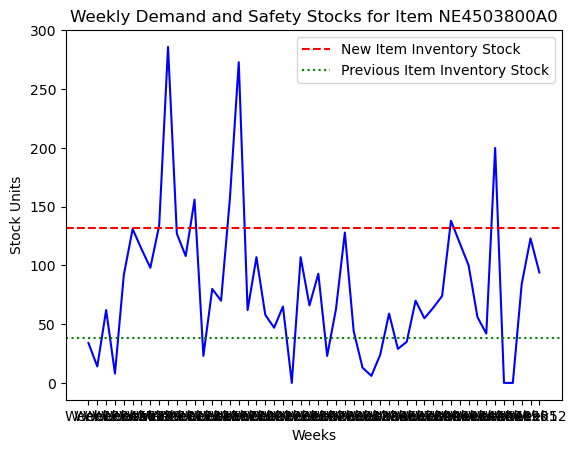

In [59]:

# Plot weekly demand
plt.plot(merge_df[merge_df['Item_Number']=='NE4503800A0'][week_columns].T.abs(), label='Weekly Demand', color='blue', linestyle='-')

# Plot new item inventory stock
plt.axhline(y=merge_df[merge_df['Item_Number']=='NE4503800A0']['Safety_Stock_cal_new1'].mean(), color='red', linestyle='--', label='New Item Inventory Stock')

# Plot previous item inventory stock
plt.axhline(y=merge_df[merge_df['Item_Number']=='NE4503800A0']['Safety Stock'].mean(), color='green', linestyle=':', label='Previous Item Inventory Stock')

# Additional configurations
plt.title('Weekly Demand and Safety Stocks for Item NE4503800A0')
plt.xlabel('Weeks')
plt.ylabel('Stock Units')
plt.legend()
plt.grid(False)

# Show the plot
plt.show()



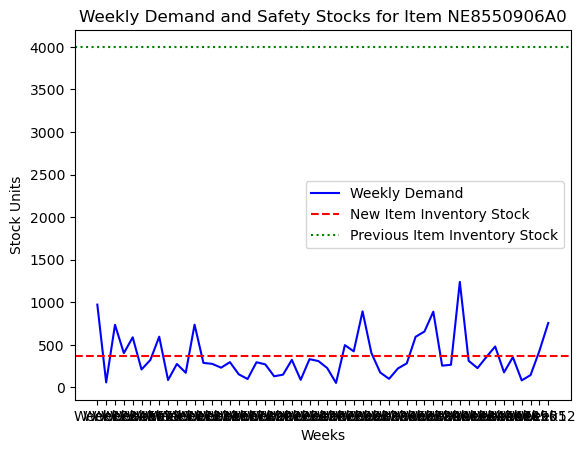

In [60]:

# Plot weekly demand
plt.plot(merge_df[merge_df['Item_Number']=='NE8550906A0'][week_columns].T.abs(), label='Weekly Demand', color='blue', linestyle='-')

# Plot new item inventory stock
plt.axhline(y=merge_df[merge_df['Item_Number']=='NE8550906A0']['Safety_Stock_cal_new1'].mean(), color='red', linestyle='--', label='New Item Inventory Stock')

# Plot previous item inventory stock
plt.axhline(y=merge_df[merge_df['Item_Number']=='NE8550906A0']['Safety Stock'].mean(), color='green', linestyle=':', label='Previous Item Inventory Stock')

# Additional configurations
plt.title('Weekly Demand and Safety Stocks for Item NE8550906A0')
plt.xlabel('Weeks')
plt.ylabel('Stock Units')
plt.legend()
plt.grid(False)

# Show the plot
plt.show()


### Safety stock model

In [57]:
df_final=merge_df[['ABC_Class','Minimum_Order_Quantity','Total 52 Weeks','mean','Lead Time','weighted_spending_proportion_score','Safety_Stock_cal_new1']]

In [58]:
X=df_final.iloc[:,0:-1]
y=df_final.iloc[:,-1]

In [61]:
dummies_df=pd.get_dummies(df_final[['ABC_Class']])

In [87]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
moq_scale=pd.DataFrame(sc.fit_transform(X.iloc[:,1:2]))
moq_scale.columns=['Minimum_Order_Quantity']
t52w_scale=pd.DataFrame(sc.fit_transform(X.iloc[:,2:3]))
t52w_scale.columns=['Total 52 Weeks']
lt_scale=pd.DataFrame(sc.fit_transform(X.iloc[:,4:5]))
lt_scale.columns=['Lead Time']

In [88]:
X_final=pd.concat([dummies_df,moq_scale,t52w_scale,X['mean'],lt_scale,X['weighted_spending_proportion_score']],axis=1)

In [91]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_final,y, test_size=0.30)

In [53]:
from sklearn.linear_model import LinearRegression 

In [89]:
X_final.columns.astype(str)

Index(['ABC_Class_A', 'ABC_Class_AA', 'ABC_Class_B', 'ABC_Class_C',
       'ABC_Class_D', 'Minimum_Order_Quantity', 'Total 52 Weeks', 'mean',
       'Lead Time', 'weighted_spending_proportion_score'],
      dtype='object')

In [92]:
lr=LinearRegression()
lr.fit(X_train,y_train)

In [122]:
import pickle
with open("safety_stock_model.pickle","wb") as f:
    pickle.dump(lr,f)

In [123]:
with open("safety_stock_model.pickle","rb") as f:
        model=pickle.load(f)

In [109]:
y_pred=pd.DataFrame(lr.predict(X_test))

In [110]:
pd.concat([y_pred,y_test.reset_index(drop=True)],axis=1)

,0,Safety_Stock_cal_new1
0,9.305788,0.000000
1,48.530017,53.360899
2,39.686265,10.734997
3,14.083514,7.452473
4,39.064849,0.000000
...,...,...
1748,149.611323,143.160302
1749,-4.677850,0.000000
1750,13.775310,0.000000
1751,-6.844340,0.000000


In [114]:
from sklearn.metrics import r2_score,mean_squared_error
print(mean_squared_error(y_pred,y_test))
r2_score(y_pred,y_test)

2055.825527224633


0.7593701653960491

In [61]:
df_final=merge_df[['ABC_Class','Minimum_Order_Quantity','Total 52 Weeks','mean','Lead Time','weighted_spending_proportion_score','Safety_Stock_cal_new1']]

In [62]:
X=df_final.iloc[:,0:-1]
y=df_final.iloc[:,-1]

In [63]:
dummies_df=pd.get_dummies(df_final[['ABC_Class']])

In [64]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
moq_scale=pd.DataFrame(sc.fit_transform(X.iloc[:,1:2]))
moq_scale.columns=['Minimum_Order_Quantity']
t52w_scale=pd.DataFrame(sc.fit_transform(X.iloc[:,2:3]))
t52w_scale.columns=['Total 52 Weeks']
lt_scale=pd.DataFrame(sc.fit_transform(X.iloc[:,4:5]))
lt_scale.columns=['Lead Time']

In [65]:
X_final=pd.concat([dummies_df,moq_scale,t52w_scale,X['mean'],lt_scale,X['weighted_spending_proportion_score']],axis=1)

In [66]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_final,y, test_size=0.30)

### Safety stock model

In [67]:
from sklearn.linear_model import LinearRegression 

In [68]:
X_final.columns.astype(str)

Index(['ABC_Class_A', 'ABC_Class_AA', 'ABC_Class_B', 'ABC_Class_C',
       'ABC_Class_D', 'Minimum_Order_Quantity', 'Total 52 Weeks', 'mean',
       'Lead Time', 'weighted_spending_proportion_score'],
      dtype='object')

In [69]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [122]:
import pickle
with open("safety_stock_model.pickle","wb") as f:
    pickle.dump(lr,f)

In [70]:
y_pred=pd.DataFrame(lr.predict(X_test))

In [72]:
from sklearn.metrics import r2_score,mean_squared_error
print(mean_squared_error(y_pred,y_test))
r2_score(y_pred,y_test)

1300.0310936543854


0.8370120182808967